In [1]:
import struct as st
import numpy as np

# Helper function to parse IDX files
def parse_idx(file_path):
    with open(file_path, 'rb') as file:
        magic = st.unpack('>I', file.read(4))[0]  # Magic number (4 bytes)
        num_items = st.unpack('>I', file.read(4))[0]  # Number of items (4 bytes)

        if magic == 2051:  # Magic number for images
            num_rows = st.unpack('>I', file.read(4))[0]
            num_cols = st.unpack('>I', file.read(4))[0]
            num_bytes = num_items * num_rows * num_cols
            data = np.frombuffer(file.read(num_bytes), dtype=np.uint8)
            return data.reshape(num_items, num_rows, num_cols)
        elif magic == 2049:  # Magic number for labels
            data = np.frombuffer(file.read(num_items), dtype=np.uint8)
            return data
        else:
            raise ValueError(f"Unknown magic number: {magic}")

# Parse the training data
imgarr = parse_idx('MNIST/train-images.idx3-ubyte')
labarr = parse_idx('MNIST/train-labels.idx1-ubyte')

# Parse the test data
# test_imgarr = parse_idx('t10k-images.idx3-ubyte')
# test_labarr = parse_idx('t10k-labels.idx1-ubyte')

# Normalize the image data to [0, 1]
ils = imgarr.reshape(imgarr.shape[0], -1) / 255.0  # Flatten and normalize
# test_ils = test_imgarr.reshape(test_imgarr.shape[0], -1) / 255.0  # Flatten and normalize


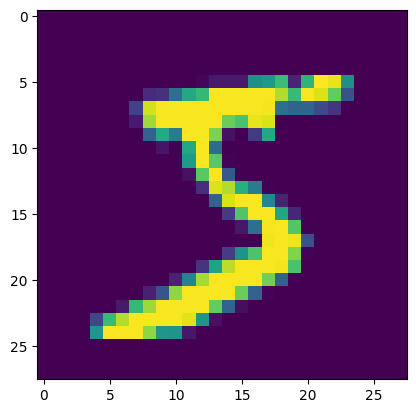

5


In [2]:
# For displaying dataset
from matplotlib import pyplot as plt
plt.imshow(imgarr[0], interpolation='nearest')
plt.show()

print(labarr[0])

In [3]:
# Initialize Ws and Bs Randomly
w0 = np.random.uniform(low=-1, high=1, size=(784, 16))
w1 = np.random.uniform(low=-1, high=1, size=(16, 16))
w2 = np.random.uniform(low=-1, high=1, size=(16, 10))

b0 = np.random.uniform(low=-1, high=1, size=16)
b1 = np.random.uniform(low=-1, high=1, size=16)
b2 = np.random.uniform(low=-1, high=1, size=10)

Ws = [w0, w1, w2]
Bs = [b0, b1, b2]

In [4]:
# ReLU Activation Function
def ReLU(arr):
    return np.maximum(0, arr)

# ReLU Derivative
def dReLU(arr):
    return (arr > 0).astype(float)

# One hot encode labels
def one_hot(labarr):
    out = np.zeros(shape=(labarr.size, 10))
    out[np.arange(labarr.size), labarr] = 1
    return out

# Softmax
def softmax(arr):
    if arr.ndim == 1:  # Single input
        exps = np.exp(arr - np.max(arr))  # Subtract max for numerical stability
        return exps / np.sum(exps)
    else:  # Batched inputs
        exps = np.exp(arr - np.max(arr, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)



In [5]:
def feed_forward(ils, Ws, Bs):
    layers = [ils]
    zs = []

    for w, b in zip(Ws, Bs):
        zs.append(np.matmul(layers[-1], w) + b)  # Linear transformation
        layers.append(ReLU(zs[-1]))  # ReLU activation

    # Final layer: Softmax activation
    logits = layers[-1]
    ps = softmax(logits)

    return layers, zs, ps


def cross_entropy_loss(ols, labarr):
    labs = one_hot(labarr)
    return -np.mean(np.sum(labs * np.log(ols + 1e-15), axis=1))


In [6]:
def backprop(layers, Zs, Ws, Bs, ps, vals):
    wgrads = []
    bgrads = []

    # Initial gradient (loss gradient wrt softmax output)
    delta = ps - vals

    # Iterate backward through layers
    for i in range(len(Ws) - 1, -1, -1):
        # Weight gradient
        wgrad = np.dot(layers[i].T, delta) / layers[i].shape[0]
        bgrad = np.sum(delta, axis=0) / layers[i].shape[0]

        # Store gradients
        wgrads.insert(0, wgrad)
        bgrads.insert(0, bgrad)

        # Calculate delta for previous layer if not the input layer
        if i > 0:
            delta = np.dot(delta, Ws[i].T) * dReLU(Zs[i - 1])

    return wgrads, bgrads


In [7]:
def train_batch(batch, labs, Ws, Bs, lr, iters=10):
    vals = one_hot(labs)
    for _ in range(iters):
        layers, Zs, ps = feed_forward(batch, Ws, Bs)
        wgs, bgs = backprop(layers, Zs, Ws, Bs, ps, vals)

        for i in range(len(Ws)):
            Ws[i] -= lr * wgs[i]
            Bs[i] -= lr * bgs[i]
    return Ws, Bs

def grad_descent(ils, labarr, batch_size, lr, Ws, Bs, epochs=10):
    n_samples = len(ils)
    for epoch in range(epochs):
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            Ws, Bs = train_batch(ils[start:end], labarr[start:end], Ws, Bs, lr)

        # Decay the learning rate after each epoch
        lr *= 0.9  # Adjust the decay factor as needed
    return Ws, Bs

Ws, Bs = grad_descent(
    ils[:59000], 
    labarr[:59000], 
    batch_size=100, 
    lr=0.05, 
    Ws=Ws, 
    Bs=Bs, 
    epochs=10
)

In [8]:
def single_forward_pass(img, Ws, Bs):
    cur = img

    for i in range(len(Ws)):
        cur = np.dot(cur, Ws[i]) + Bs[i]
        if i < len(Ws) - 1:
            cur = ReLU(cur)
        else:
            cur = softmax(cur)
    predicted_class = np.argmax(cur)
    return predicted_class, cur

accuracy = 0
for i in range(1000):
    pred, probs = single_forward_pass(ils[59000 + i], Ws, Bs)
    print(f"Prediction: {pred}, Actual: {labarr[59000 + i]}, Confidence: {probs[pred]:.2f}")
    
    if pred == labarr[59000 + i]:
        accuracy += 1
print(f"Accuracy: {accuracy / 1000}")

Prediction: 6, Actual: 6, Confidence: 0.98
Prediction: 3, Actual: 3, Confidence: 0.81
Prediction: 5, Actual: 5, Confidence: 1.00
Prediction: 7, Actual: 7, Confidence: 1.00
Prediction: 2, Actual: 2, Confidence: 1.00
Prediction: 5, Actual: 5, Confidence: 1.00
Prediction: 9, Actual: 9, Confidence: 1.00
Prediction: 2, Actual: 2, Confidence: 1.00
Prediction: 6, Actual: 6, Confidence: 1.00
Prediction: 2, Actual: 2, Confidence: 1.00
Prediction: 1, Actual: 1, Confidence: 1.00
Prediction: 2, Actual: 2, Confidence: 1.00
Prediction: 0, Actual: 0, Confidence: 1.00
Prediction: 8, Actual: 8, Confidence: 0.99
Prediction: 3, Actual: 3, Confidence: 0.99
Prediction: 8, Actual: 8, Confidence: 0.99
Prediction: 3, Actual: 3, Confidence: 1.00
Prediction: 0, Actual: 0, Confidence: 1.00
Prediction: 8, Actual: 8, Confidence: 0.99
Prediction: 7, Actual: 7, Confidence: 0.99
Prediction: 4, Actual: 4, Confidence: 0.64
Prediction: 9, Actual: 9, Confidence: 0.99
Prediction: 5, Actual: 5, Confidence: 1.00
Prediction: